In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random
from scipy.optimize import curve_fit

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 2
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

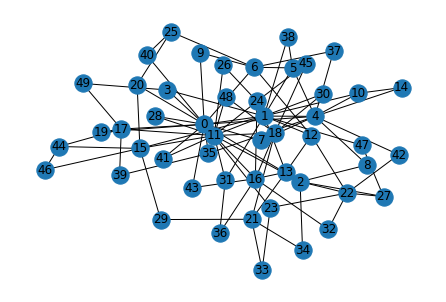

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

Distribuzione della connettività dei nodi

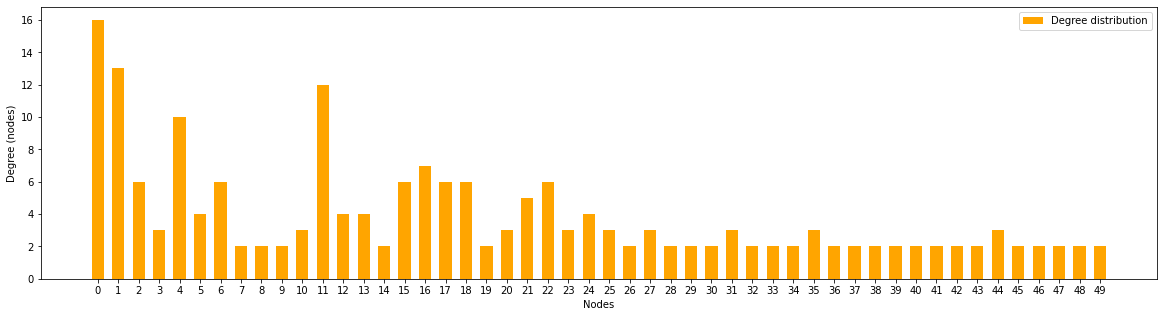

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(G.nodes, [d for n,d in G.degree], width=0.6, 
          align='center', color='orange', label='Degree distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Degree (nodes)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

Estrazione della matrice di adiacenza A

In [5]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [6]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [7]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)
pS = autovettoriP[0]
if pS[0] < 0:
    pS = -pS
#np.dot(np.transpose(matrix),autovettori[0])

In [8]:
autovaloriP

array([ 1.00000000e+00,  8.13999275e-01,  7.63410686e-01,  7.08288250e-01,
        6.52837796e-01,  6.44719006e-01, -7.87834873e-01, -7.60335336e-01,
        5.93170403e-01, -7.30299702e-01,  5.52612691e-01, -6.96566794e-01,
        5.07841128e-01, -6.50269955e-01,  4.58592910e-01,  4.21895164e-01,
        4.03110305e-01,  3.79947547e-01,  3.58978603e-01,  3.09476322e-01,
        3.04218452e-01,  2.78225279e-01,  2.44720351e-01,  1.93958301e-01,
        1.66747151e-01,  1.30012566e-01,  8.26301680e-02,  3.90637805e-02,
       -5.72027490e-01, -5.62844661e-01, -5.45424000e-01, -5.86440502e-02,
       -9.73858189e-02, -1.52802106e-01, -5.02719605e-01, -4.76945604e-01,
       -2.11736065e-01, -2.48571120e-01, -4.42019037e-01, -2.90789998e-01,
       -3.17966905e-01, -3.34740045e-01, -4.03844478e-01, -3.99093667e-01,
       -3.80238058e-01, -3.85356767e-01,  9.37470555e-17,  2.92288933e-17,
       -5.05137369e-17, -2.25194382e-17])

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [9]:
matrixL = np.identity(N) - matrixP

In [10]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)
pS_L = autovettoriL[0]
if pS_L[0] < 0:
    pS_L = -pS_L

In [11]:
autovaloriL

array([-4.71844785e-16,  1.86000725e-01,  2.36589314e-01,  2.91711750e-01,
        3.47162204e-01,  3.55280994e-01,  4.06829597e-01,  4.47387309e-01,
        1.78783487e+00,  1.76033534e+00,  4.92158872e-01,  1.73029970e+00,
        1.69656679e+00,  5.41407090e-01,  5.78104836e-01,  5.96889695e-01,
        6.20052453e-01,  6.41021397e-01,  6.90523678e-01,  6.95781548e-01,
        7.21774721e-01,  7.55279649e-01,  8.06041699e-01,  8.33252849e-01,
        8.69987434e-01,  9.17369832e-01,  9.60936219e-01,  1.65026995e+00,
        1.05864405e+00,  1.09738582e+00,  1.15280211e+00,  1.57202749e+00,
        1.56284466e+00,  1.54542400e+00,  1.21173606e+00,  1.24857112e+00,
        1.50271960e+00,  1.47694560e+00,  1.29079000e+00,  1.44201904e+00,
        1.31796690e+00,  1.33474005e+00,  1.40384448e+00,  1.39909367e+00,
        1.38023806e+00,  1.38535677e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [12]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [14]:
FiedlerValue = round(min(autovaloriL[1:]), i)
print(FiedlerValue)

0.1860007253953


In [15]:
pS = np.round(pS.real, i)
print(pS)

[0.46111233 0.37465377 0.17291713 0.08645856 0.28819521 0.11527808
 0.17291713 0.05763904 0.05763904 0.05763904 0.08645856 0.34583425
 0.11527808 0.11527808 0.05763904 0.17291713 0.20173665 0.17291713
 0.17291713 0.05763904 0.08645856 0.1440976  0.17291713 0.08645856
 0.11527808 0.08645856 0.05763904 0.08645856 0.05763904 0.05763904
 0.05763904 0.08645856 0.05763904 0.05763904 0.05763904 0.08645856
 0.05763904 0.05763904 0.05763904 0.05763904 0.05763904 0.05763904
 0.05763904 0.05763904 0.08645856 0.05763904 0.05763904 0.05763904
 0.05763904 0.05763904]


Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [16]:
walker_per_node = 200

In [17]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [18]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [19]:
time_steps = int(1e2)

In [20]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
#         t1 = time.time()
        dynamic_evolution(G, history[h])
#         print(f"done in {int((time.time()-t1)/60)} minutes and {((time.time()-t1)%60)} seconds")

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 33.36424517631531 seconds


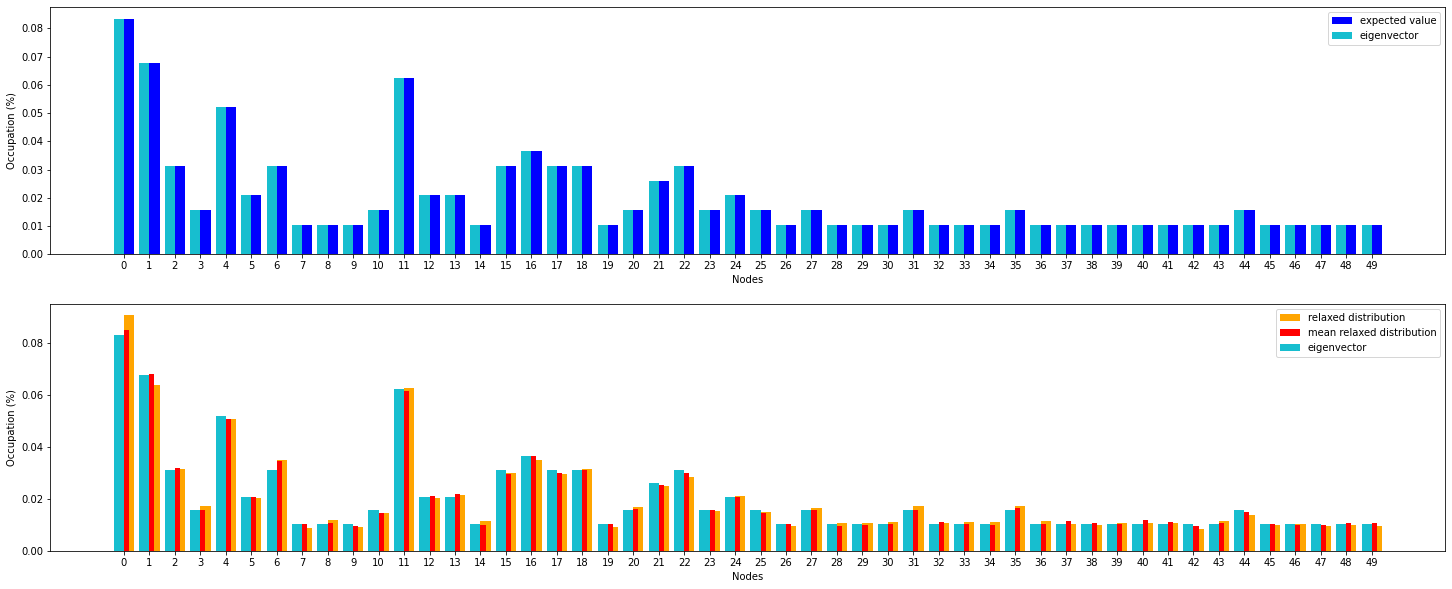

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSExpected = [d for n, d in G.degree()]
pSNorm = [h/sum(pS) for h in pS]

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSExpected) for h in pSExpected], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h for h in pSNorm], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

In [22]:
print(pSNorm)

[0.08333333333334854, 0.06770833333335247, 0.03125000000001022, 0.015624999999996073, 0.05208333333333831, 0.0208333333333281, 0.03125000000001022, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.015624999999996073, 0.06250000000000237, 0.0208333333333281, 0.0208333333333281, 0.01041666666666405, 0.03125000000001022, 0.036458333333342245, 0.03125000000001022, 0.03125000000001022, 0.01041666666666405, 0.015624999999996073, 0.026041666666678197, 0.03125000000001022, 0.015624999999996073, 0.0208333333333281, 0.015624999999996073, 0.01041666666666405, 0.015624999999996073, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.015624999999996073, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.015624999999996073, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.01041666666666405, 0.015624999999996073, 0.01041666666666405, 0.01041666666666405, 0.010

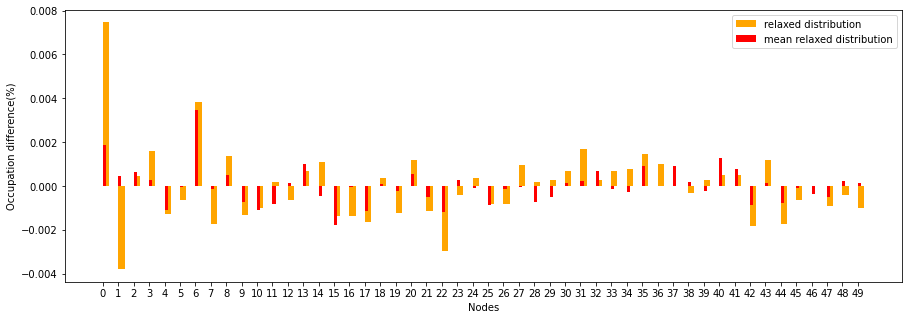

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
       align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k 
                 for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
       width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

In [24]:
def gaus_law(x, a, mu=459, sigma=1):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

from scipy.stats import binom
from scipy.stats import poisson

def binomial_law(x, n, p):
    return binom.pmf(x, n, p)

def poisson_law(x, lamb):
    return poisson.cdf(x, lamb)

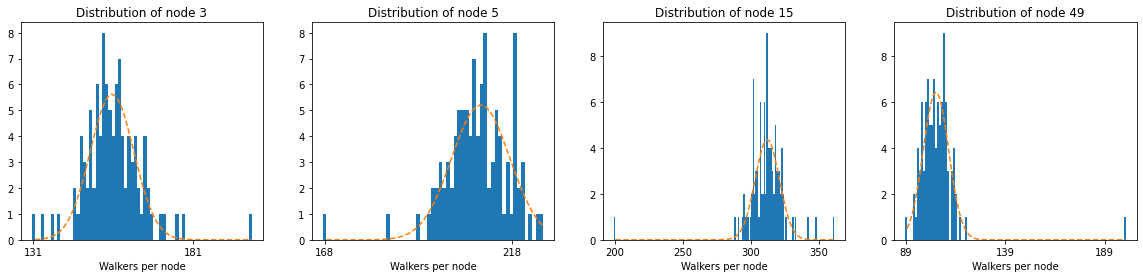

In [36]:
nodes = [3, 5, 15, N-1]
p_node = []

fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(5*len(nodes), 4))

histo = [[(h1+h2+h3)/3 for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

n = [0]*len(nodes)
bins = [0]*len(nodes)

for i in range(len(nodes)):
    p_node += [[int(h[nodes[i]]) for h in histo]]
    n[i], bins[i], patches = ax[i].hist(p_node[i], bins = int((max(p_node[i]) - min(p_node[i]))), align='left')
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_xlabel("Walkers per node")
    ax[i].set_xticks(np.arange(min(p_node[i]), max(p_node[i]), 50))
    
mean = [sum(p_node[i])/len(p_node[i]) for i in range(len(nodes))]

popt = [0]*len(nodes)
pcov = [0]*len(nodes)

for i in range(len(nodes)):
    bins[i]=(bins[i][:-1] + bins[i][1:])/2
    
    popt[i], pcov[i] = curve_fit(gaus_law, bins[i], n[i], p0 = [10, mean[i], 9])
#     popt[i], pcov[i] = curve_fit(binomial_law, bins[i], n[i], p0 = [walker_per_node*N, pS[nodes[i]]])
    
    ax[i].plot(bins[i], gaus_law(bins[i], *popt[i]), '--')

plt.show()

In [35]:
for i in range(len(nodes)):
    print("DIstribution for node", nodes[i], ":")
    print(" - Data mean:", mean[i])
    print(" - Expected mean from eigenvector:", pSNorm[nodes[i]] * N * walker_per_node)
    print(" - Mean from gaussian fit:", popt[i][1])
    print()

DIstribution for node 3 :
 - Data mean: 157.43
 - Expected mean from eigenvector: 156.24999999996072
 - Mean from gaussian fit: 155.66564434216673

DIstribution for node 5 :
 - Data mean: 210.99
 - Expected mean from eigenvector: 208.333333333281
 - Mean from gaussian fit: 209.76941224339524

DIstribution for node 15 :
 - Data mean: 314.1
 - Expected mean from eigenvector: 312.5000000001022
 - Mean from gaussian fit: 312.1893451301102

DIstribution for node 49 :
 - Data mean: 105.68
 - Expected mean from eigenvector: 104.1666666666405
 - Mean from gaussian fit: 104.08064578579497



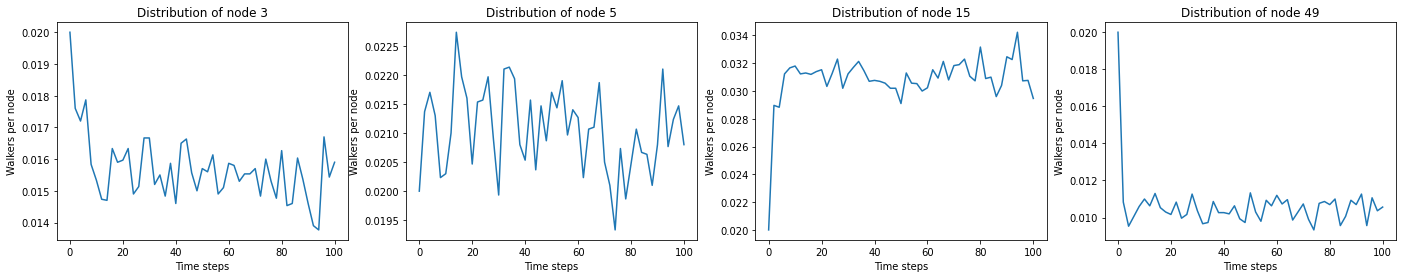

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(6*len(nodes), 4))

time_range = hMean
index = np.arange(0, len(time_range), 2)

for i in range(len(nodes)):
    ax[i].plot(index, [time_range[ind][nodes[i]] for ind in index])
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_ylabel("Walkers per node")
    ax[i].set_xlabel("Time steps")

plt.show()

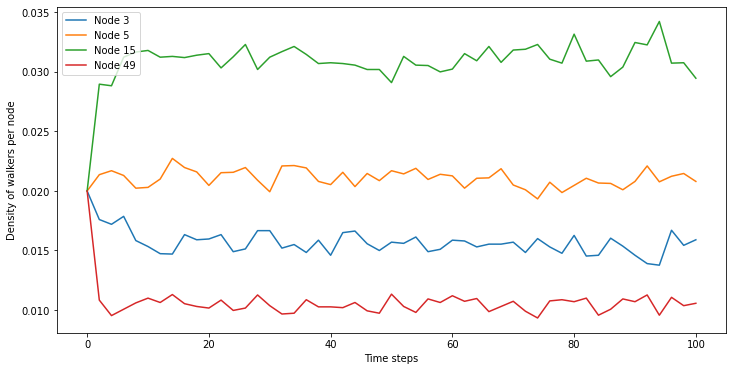

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))

for i in nodes: #list(G.nodes)[0:3]:
    plt.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}")
#     plt.plot(index, [time_range[ind][i] for ind in index])
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

#### Note:

* aggiungere fit su distribuzioni di walkers

* sistema grafica concentrazioni di individui su ogni nodo

* fare grafico per fittare valore di Fiedler